In [2]:
#Importing Libraries
import numpy as np
import dask.dataframe as dd
import pandas as pd
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib import rcParams
from sklearn.cluster import MiniBatchKMeans, KMeans
from datetime import datetime, timedelta
from datetime import datetime
from tqdm import tqdm
import math
import pickle
import os
import time
import datetime
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error,r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import warnings
warnings.filterwarnings("ignore")

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
sept_df = pd.read_parquet('/content/drive/MyDrive/yellow_tripdata_2022-09.parquet')  
sept_df.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-09-01 00:28:12,2022-09-01 00:36:22,1.0,2.10,1.0,N,100,239,1,9.0,3.0,0.5,1.8,0.00,0.3,14.60,2.5,0.0
1,1,2022-09-01 00:51:58,2022-09-01 01:14:43,1.0,8.70,1.0,N,161,243,2,27.5,3.0,0.5,0.0,0.00,0.3,31.30,2.5,0.0
2,1,2022-09-01 00:08:29,2022-09-01 00:26:29,1.0,8.30,1.0,N,138,233,1,25.0,3.0,0.5,2.0,6.55,0.3,37.35,2.5,0.0
3,2,2022-09-01 00:02:24,2022-09-01 00:09:39,1.0,1.32,1.0,N,238,166,2,7.5,0.5,0.5,0.0,0.00,0.3,8.80,0.0,0.0
4,2,2022-09-01 00:47:25,2022-09-01 00:56:09,1.0,2.94,1.0,N,161,226,2,10.5,0.5,0.5,0.0,0.00,0.3,14.30,2.5,0.0


In [11]:
sept_df.shape

(3183767, 19)

In [12]:
sept_df.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
count,3183767.00000,3067175.00000,3183767.00000,3067175.00000,3183767.00000,3183767.00000,3183767.00000,3183767.00000,3183767.00000,3183767.00000,3183767.00000,3183767.00000,3183767.00000,3183767.00000,3067175.00000,3067175.00000
mean,1.71538,1.38632,7.10928,1.48346,164.38203,162.14471,1.18687,15.64404,1.00398,0.48768,2.88693,0.60428,0.29577,22.65776,2.26822,0.10835
std,0.45124,0.93756,736.50358,6.17980,65.57936,70.37223,0.52702,106.23748,1.24954,0.09916,3.43264,2.13266,0.04964,106.82551,0.77100,0.35583
min,1.00000,0.00000,0.00000,1.00000,1.00000,1.00000,0.00000,-800.00000,-5.50000,-0.55000,-92.18000,-34.50000,-0.30000,-790.30000,-2.50000,-1.25000
25%,1.00000,1.00000,1.13000,1.00000,132.00000,113.00000,1.00000,7.50000,0.00000,0.50000,1.00000,0.00000,0.30000,12.36000,2.50000,0.00000
50%,2.00000,1.00000,1.94000,1.00000,161.00000,162.00000,1.00000,11.00000,0.50000,0.50000,2.22000,0.00000,0.30000,16.56000,2.50000,0.00000
75%,2.00000,1.00000,3.78000,1.00000,234.00000,234.00000,1.00000,17.50000,2.50000,0.50000,3.56000,0.00000,0.30000,24.36000,2.50000,0.00000
max,5.00000,9.00000,303133.41000,99.00000,265.00000,265.00000,4.00000,187444.96000,28.00000,3.30000,711.22000,156.00000,0.30000,187448.26000,2.75000,1.25000


* Passenger count has a minimum of 0 which means either it is an error entered or the drivers deliberately entered 0 to complete a target number of rides.
* The minimum values in other continuous variable is also 0. We will come back to this later during Univariate Analysis.

### Data Cleaning

In [13]:
sept_df.isnull().sum()

VendorID                      0
tpep_pickup_datetime          0
tpep_dropoff_datetime         0
passenger_count          116592
trip_distance                 0
RatecodeID               116592
store_and_fwd_flag       116592
PULocationID                  0
DOLocationID                  0
payment_type                  0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
improvement_surcharge         0
total_amount                  0
congestion_surcharge     116592
airport_fee              116592
dtype: int64

In [14]:
print(float(sept_df['passenger_count'].isnull().sum())*100/sept_df.shape[0])
sept_df.dropna(inplace=True)
sept_df.shape

3.6620770301344288


(3067175, 19)

As there are only 3% missing values in passenger_count, RatecodeID, store_and_fwd_flag, congestion_surcharge, airport_fee, we can drop those records.

In [15]:
sept_df['tpep_pickup_datetime']=pd.to_datetime(sept_df['tpep_pickup_datetime'])
sept_df['tpep_dropoff_datetime']=pd.to_datetime(sept_df['tpep_dropoff_datetime'])

In [16]:
sept_df['pickup_day']=sept_df['tpep_pickup_datetime'].dt.day_name()
sept_df['dropoff_day']=sept_df['tpep_dropoff_datetime'].dt.day_name()
sept_df['pickup_dayofweek']=sept_df['tpep_pickup_datetime'].dt.weekday
sept_df['dropoff_dayofweek']=sept_df['tpep_dropoff_datetime'].dt.weekday
sept_df['pickup_hour']=sept_df['tpep_pickup_datetime'].dt.hour
sept_df['dropoff_hour']=sept_df['tpep_dropoff_datetime'].dt.hour
sept_df['pickup_month']=sept_df['tpep_pickup_datetime'].dt.month
sept_df['dropoff_month']=sept_df['tpep_dropoff_datetime'].dt.month

In [17]:
sept_df = sept_df[sept_df['pickup_month'] == 9]
sept_df['dropoff_month'].unique()

array([ 9, 10])

In [18]:
def time_of_day(x):
    if x in range(6,12):
        return 'Morning'
    elif x in range(12,16):
        return 'Afternoon'
    elif x in range(16,22):
        return 'Evening'
    else:
        return 'Late night'

In [19]:
sept_df['pickup_timeofday']=sept_df['pickup_hour'].apply(time_of_day)
sept_df['dropoff_timeofday']=sept_df['dropoff_hour'].apply(time_of_day)

#Caluclating Trip duration from pickup time and dropoff time
duration = sept_df[['tpep_pickup_datetime','tpep_dropoff_datetime']]
#pickups and dropoffs to unix time
duration_pickup = [time.mktime(datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").timetuple()) for x in duration['tpep_pickup_datetime']]
duration_drop = [time.mktime(datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").timetuple()) for x in duration['tpep_dropoff_datetime']]
#calculate duration of trips
durations = (np.array(duration_drop) - np.array(duration_pickup))/float(60)
sept_df['trip_duration'] = durations
sept_df['speed'] = 60*(sept_df['trip_distance']/sept_df['trip_duration'])
sept_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,pickup_dayofweek,dropoff_dayofweek,pickup_hour,dropoff_hour,pickup_month,dropoff_month,pickup_timeofday,dropoff_timeofday,trip_duration,speed
0,1,2022-09-01 00:28:12,2022-09-01 00:36:22,1.0,2.10,1.0,N,100,239,1,...,3,3,0,0,9,9,Late night,Late night,8.166667,15.428571
1,1,2022-09-01 00:51:58,2022-09-01 01:14:43,1.0,8.70,1.0,N,161,243,2,...,3,3,0,1,9,9,Late night,Late night,22.750000,22.945055
2,1,2022-09-01 00:08:29,2022-09-01 00:26:29,1.0,8.30,1.0,N,138,233,1,...,3,3,0,0,9,9,Late night,Late night,18.000000,27.666667
3,2,2022-09-01 00:02:24,2022-09-01 00:09:39,1.0,1.32,1.0,N,238,166,2,...,3,3,0,0,9,9,Late night,Late night,7.250000,10.924138
4,2,2022-09-01 00:47:25,2022-09-01 00:56:09,1.0,2.94,1.0,N,161,226,2,...,3,3,0,0,9,9,Late night,Late night,8.733333,20.198473


### Univariate Analysis

#### Vendor ID

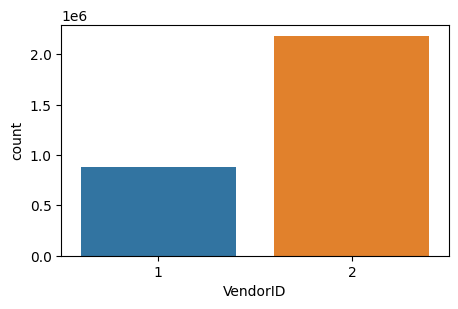

In [20]:
#Vendor ID
plt.figure(figsize = (5,3))
sns.countplot(x='VendorID',data=sept_df)
plt.show()

- Here we got to know that there are only 2 venders(1 and 2)
- Both the venders share almost equal amount of trips, the difference is quite low between two venders
- But Vendor 2 is evidently more famous among the population as per the above graphs.

#### Passenger Count

In [21]:
sept_df.passenger_count.value_counts()

1.0    2276161
2.0     479252
3.0     117437
0.0      58414
4.0      50332
5.0      49448
6.0      36018
7.0         21
8.0         10
9.0          5
Name: passenger_count, dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

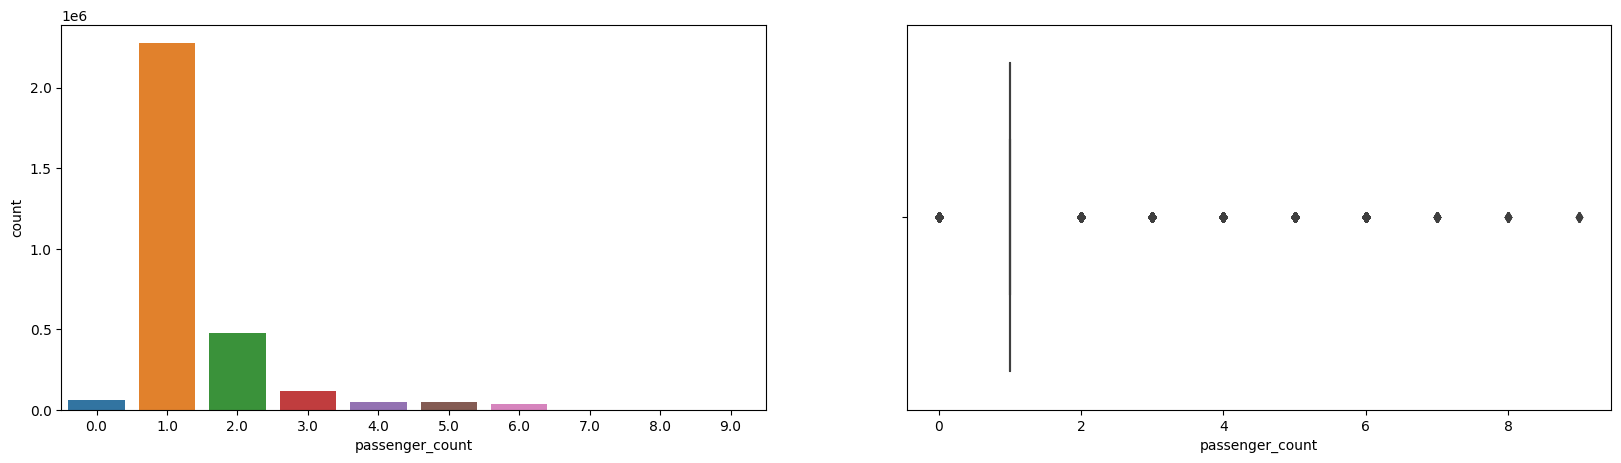

In [22]:
figure,(ax1,ax2) = plt.subplots(ncols=2,figsize=(20,5))
ax = sns.countplot(x='passenger_count',data=sept_df,ax=ax1)
ax = sns.boxplot(x='passenger_count',data=sept_df,ax=ax2)
plt.show

* Here we see that mostly 1 or 2 passengers available in the cab. The instance of large group of people travelling together are rare.
* There are some trips with even 0 passenger count.
* There are very few trips each for 7,8 and 9 passengers. According to New York City Taxi Passenger Limit maximum 5 passengers can board new york taxi i.e. 4 adult + 1 minor. So, clearly these are outliers and therefore we removed trips with 0,6,7,8,9 passenger count.

In [23]:
sept_df=sept_df[sept_df['passenger_count']!=0]
sept_df=sept_df[sept_df['passenger_count']<6]

#### Trip Duration

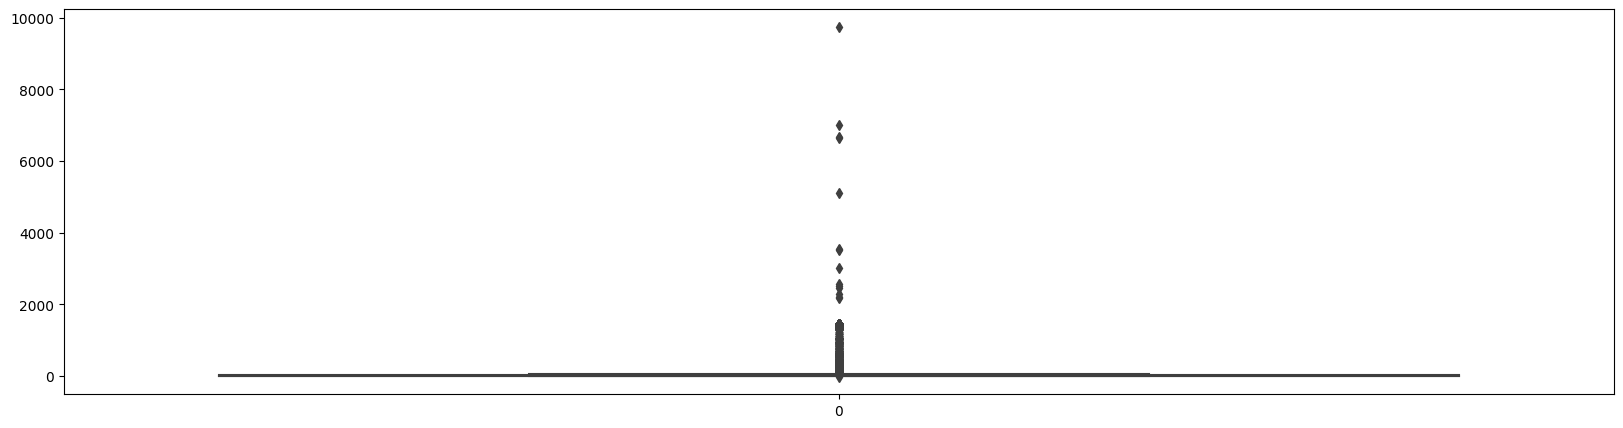

In [24]:
plt.figure(figsize = (20,5))
sns.boxplot(sept_df.trip_duration)
plt.show()

In [25]:
#calculating 0-100th percentile to find a the correct percentile value for removal of outliers
for i in range(0,100,10):
    var =sept_df["trip_duration"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is -22.15
10 percentile value is 4.783333333333333
20 percentile value is 6.866666666666666
30 percentile value is 8.8
40 percentile value is 10.816666666666666
50 percentile value is 13.083333333333334
60 percentile value is 15.783333333333333
70 percentile value is 19.3
80 percentile value is 24.433333333333334
90 percentile value is 34.4
100 percentile value is  9747.05


In [26]:
#looking further from the 99th percecntile
for i in range(90,100):
    var =sept_df["trip_duration"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

90 percentile value is 34.4
91 percentile value is 36.083333333333336
92 percentile value is 38.03333333333333
93 percentile value is 40.28333333333333
94 percentile value is 42.96666666666667
95 percentile value is 46.21666666666667
96 percentile value is 50.166666666666664
97 percentile value is 55.21666666666667
98 percentile value is 62.18333333333333
99 percentile value is 73.83333333333333
100 percentile value is  9747.05


In [27]:
#According to NYC Taxi & Limousine Commision Regulations the maximum allowed trip duration in a 24 hour interval is 12 hours.
sept_df = sept_df[(sept_df.trip_duration>1) & (sept_df.trip_duration<720)]

#### Trip Distance

In [28]:
#Trip Distance
sept_df['trip_distance'].value_counts()

1.00     39136
1.10     38881
0.90     38807
1.20     38256
1.30     36942
         ...  
65.85        1
48.73        1
44.01        1
34.59        1
31.26        1
Name: trip_distance, Length: 4610, dtype: int64

We can see there are 44450 trips with 0 km distance.
The reasons for 0 km distance can be:
* The dropoff location couldn’t be tracked.
* The driver deliberately took this ride to complete a target ride number.
* Customer changed mind and cancelled the trip just after accepting it.
* Issue with GPS tracker while the journey is being finished.
* We will analyze these trips further in bivariate analysis.

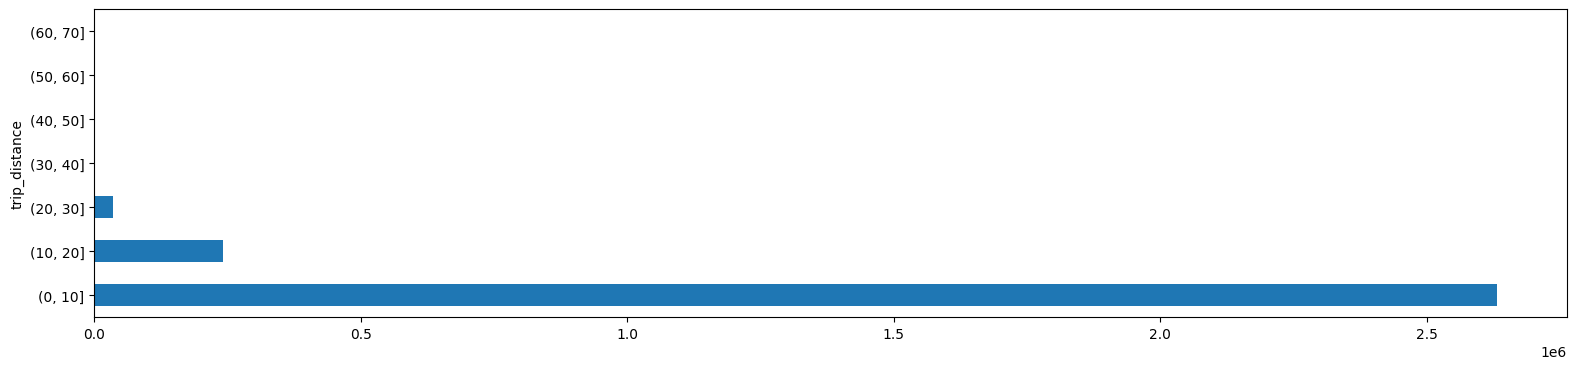

In [29]:
sept_df.trip_distance.groupby(pd.cut(sept_df.trip_distance, np.arange(0,80,10))).count().plot(kind='barh',figsize = (19,4))
plt.show()

From the above observation it is evident that most of the rides are completed between 1-10 miles with some of the rides with distances between 10-30 miles. Other slabs bar are not visible because the number of trips are very less as compared to these slabs

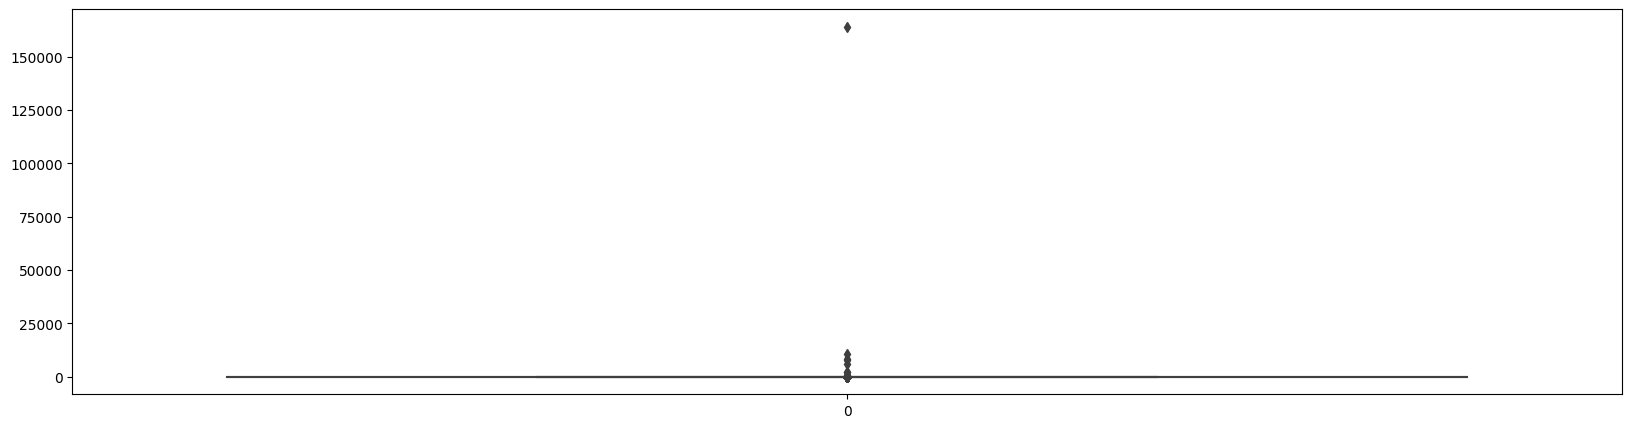

In [30]:
# box-plot showing outliers in trip-distance values
plt.figure(figsize = (20,5))
sns.boxplot(sept_df.trip_distance)
plt.show()

In [31]:
#calculating trip distance values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var =sept_df["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.0
10 percentile value is 0.74
20 percentile value is 1.01
30 percentile value is 1.3
40 percentile value is 1.6
50 percentile value is 1.94
60 percentile value is 2.41
70 percentile value is 3.17
80 percentile value is 4.7
90 percentile value is 9.72
100 percentile value is  164072.79


In [32]:
#calculating trip distance values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var =sept_df["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 9.72
91 percentile value is 10.4
92 percentile value is 11.15
93 percentile value is 12.22
94 percentile value is 14.4
95 percentile value is 16.51
96 percentile value is 17.46
97 percentile value is 18.11
98 percentile value is 18.96
99 percentile value is 20.6
100 percentile value is  164072.79


In [33]:
#calculating trip distance values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var =sept_df["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 20.6
99.1 percentile value is 20.81
99.2 percentile value is 21.08
99.3 percentile value is 21.36
99.4 percentile value is 21.71
99.5 percentile value is 22.19
99.6 percentile value is 22.88
99.7 percentile value is 24.39
99.8 percentile value is 26.84
99.9 percentile value is 30.21
100 percentile value is  164072.79


In [34]:
#removing further outliers based on the 99.9th percentile value
sept_df = sept_df[(sept_df.trip_distance>0) & (sept_df.trip_distance<30)]

#### Speed

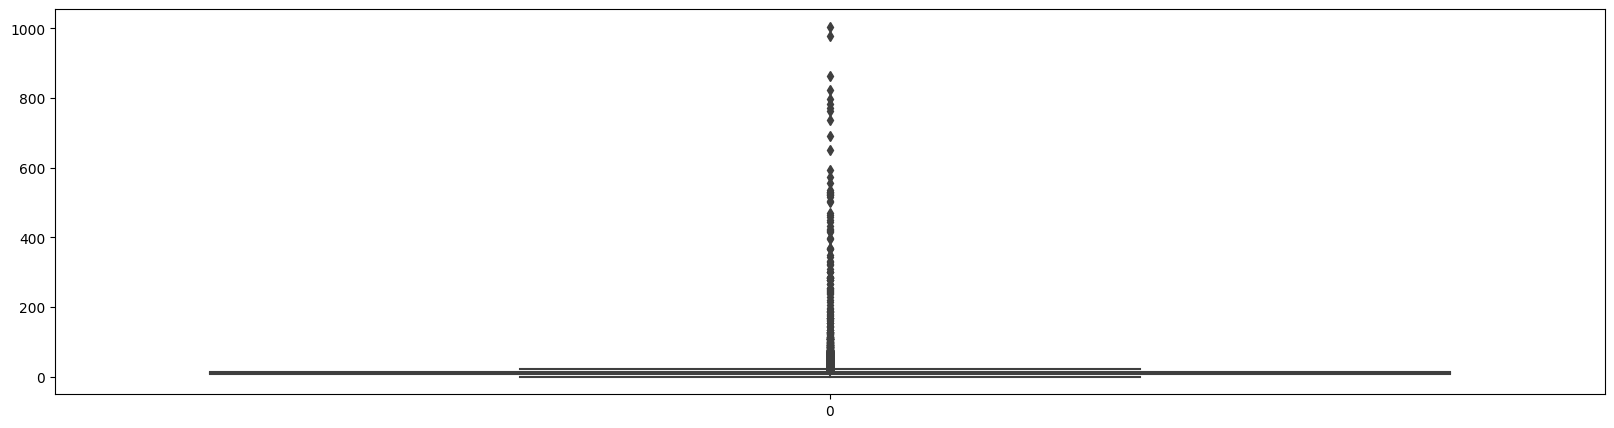

In [35]:
plt.figure(figsize = (20,5))
sns.boxplot(sept_df.speed)
plt.show()

- Many trips were done at a speed of over 130 mile/hr.
- Maximum speed limit in NYC is as 25 mph in urban area and 65 mph on controlled state highways. Hence removing reocrds where speed >65 miles/hr

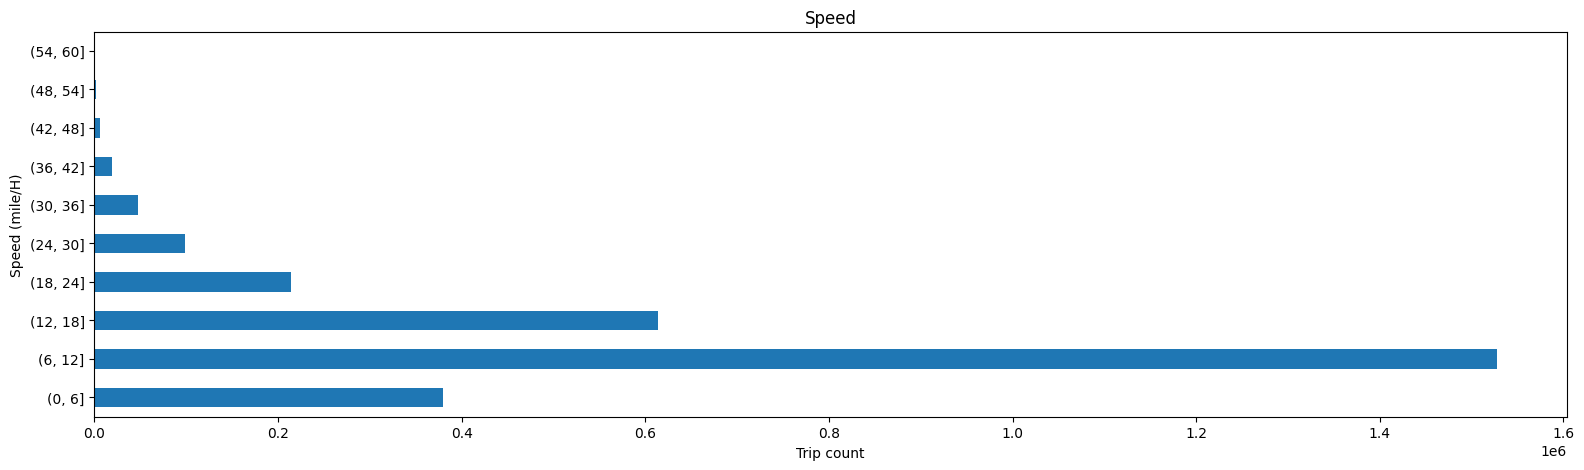

In [36]:
sept_df = sept_df[sept_df['speed']<65]
sept_df.speed.groupby(pd.cut(sept_df.speed, np.arange(0,65,6))).count().plot(kind = 'barh',figsize = (19,5))
plt.xlabel('Trip count')
plt.ylabel('Speed (mile/H)')
plt.title('Speed')
plt.show()

Mostly trips are done at a speed range of 6-12 miles/hr.

In [37]:
#avg.speed of cabs in New-York
sum(sept_df["speed"]) / float(len(sept_df["speed"]))
#The avg speed in Newyork is 11.6 miles/hr, so a cab driver can travel 2 miles per 10min on avg.

11.653134610696574

#### Trips per WeekDay

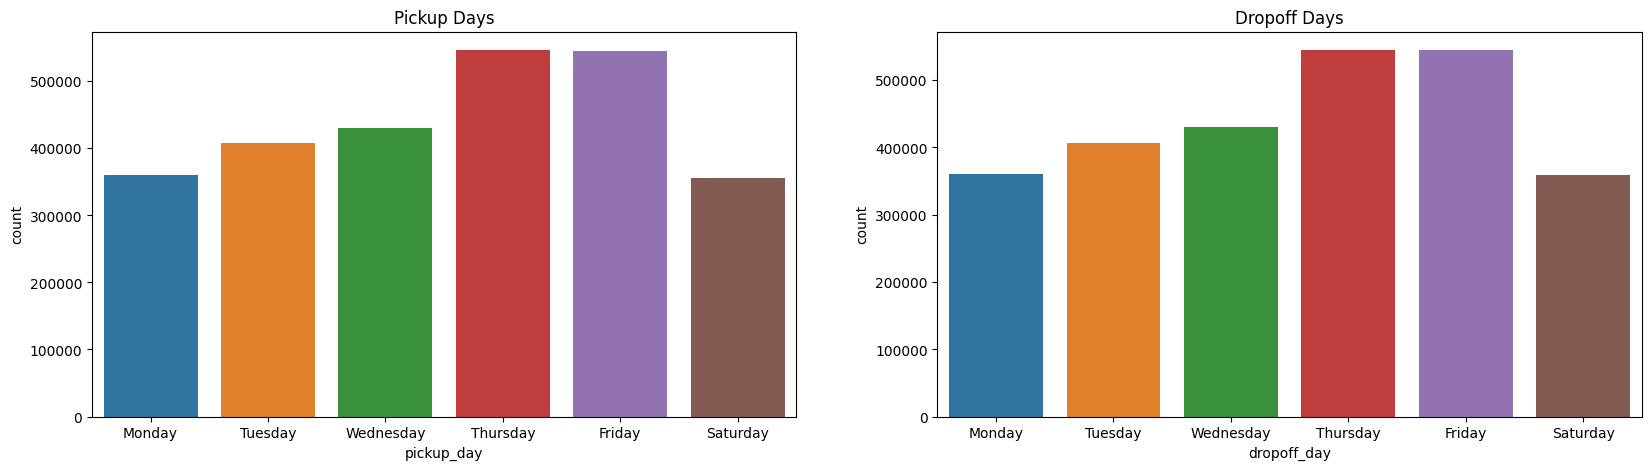

In [38]:
figure,(ax1,ax2)=plt.subplots(ncols=2,figsize=(20,5))
ax1.set_title('Pickup Days')
ax=sns.countplot(x="pickup_day",data=sept_df,ax=ax1,order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday'])
ax2.set_title('Dropoff Days')
ax=sns.countplot(x="dropoff_day",data=sept_df,ax=ax2,order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday'])

We see Thursdays and Fridays are the busiest days followed by Wednesday.

#### Trips per hour

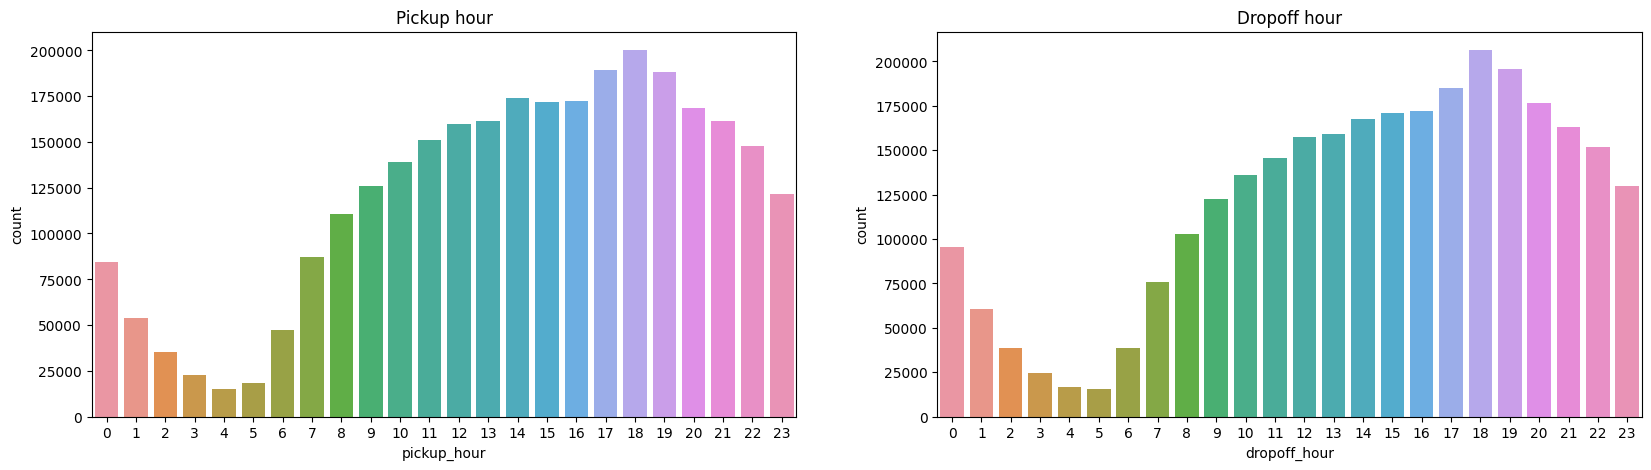

In [39]:
figure,(ax1,ax2)=plt.subplots(ncols=2,figsize=(20,5))
ax1.set_title('Pickup hour')
ax=sns.countplot(x="pickup_hour",data=sept_df,ax=ax1)
ax2.set_title('Dropoff hour')
ax=sns.countplot(x="dropoff_hour",data=sept_df,ax=ax2)

#### Trips per Time of Day

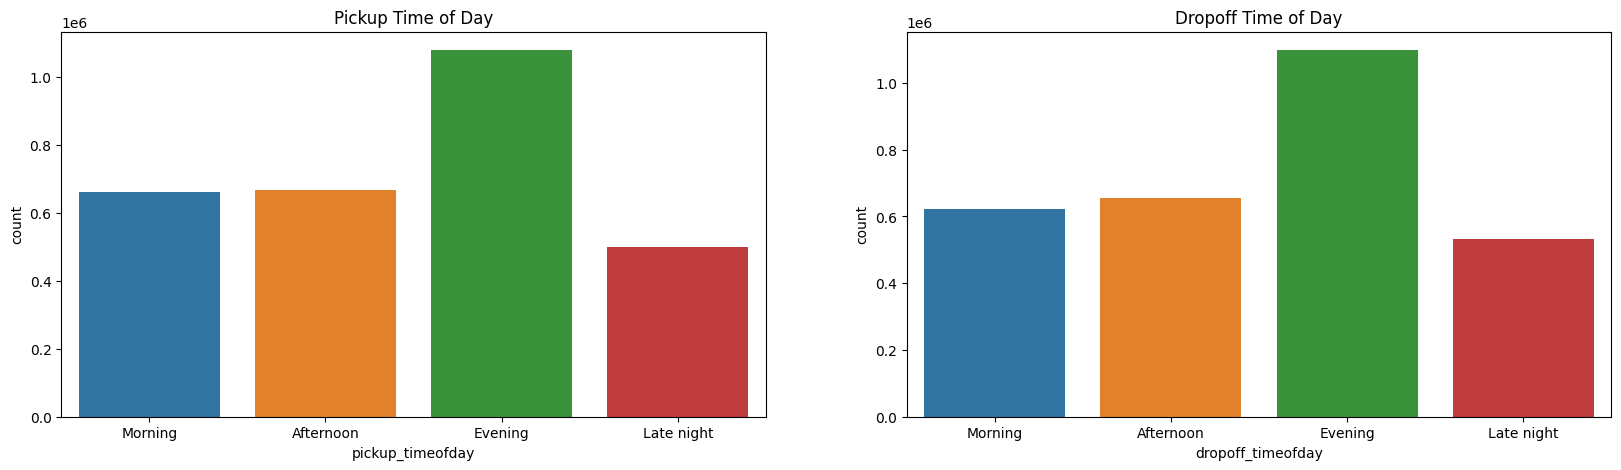

In [40]:
#Evening - 4:00 PM - 10:00PM
#Late Night - 10:00PM - 4:00 AM
figure,(ax1,ax2)=plt.subplots(ncols=2,figsize=(20,5))
ax1.set_title('Pickup Time of Day')
ax=sns.countplot(x="pickup_timeofday",data=sept_df,ax=ax1,order=['Morning','Afternoon','Evening','Late night'])
ax2.set_title('Dropoff Time of Day')
ax=sns.countplot(x="dropoff_timeofday",data=sept_df,ax=ax2,order=['Morning','Afternoon','Evening','Late night'])

We observe that most pickups and drops occur in the evening followed by Afternoon. While the least drops and pickups occur during Late night.

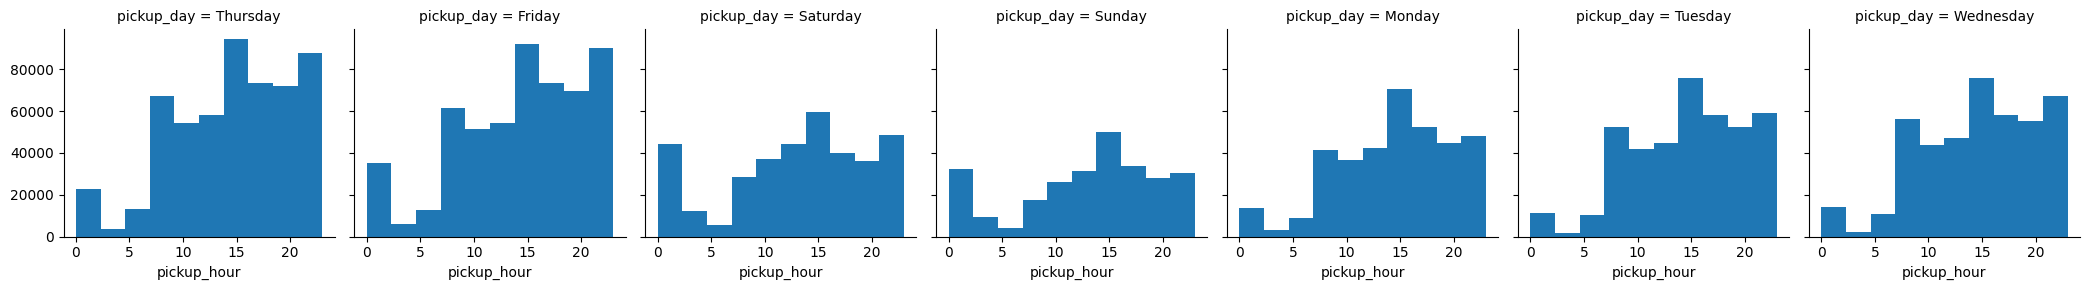

In [41]:
n = sns.FacetGrid(sept_df, col='pickup_day')
n.map(plt.hist, 'pickup_hour')
plt.show()

- Taxi pickups increased in the late night hours over the weekend possibly due to more outstation rides or for the late night leisures nearby activities.
- Early morning pickups i.e before 5 AM have increased over the weekend in comparison to the office hours pickups i.e. after 7 AM which have decreased due to obvious reasons.

###  BiVariate Analysis

In [47]:
group1

pickup_hour
0     14.299984
1     12.890395
2     12.327302
3     12.459515
4     14.347304
5     15.898396
6     15.340627
7     16.227662
8     17.365420
9     16.932594
10    17.002884
11    17.723867
12    18.459161
13    19.201283
14    20.262640
15    21.085028
16    20.659705
17    19.356016
18    17.133715
19    16.009594
20    15.339337
21    14.991439
22    15.192164
23    15.269536
Name: trip_duration, dtype: float64

#### Trip Duration per hour and Weekday

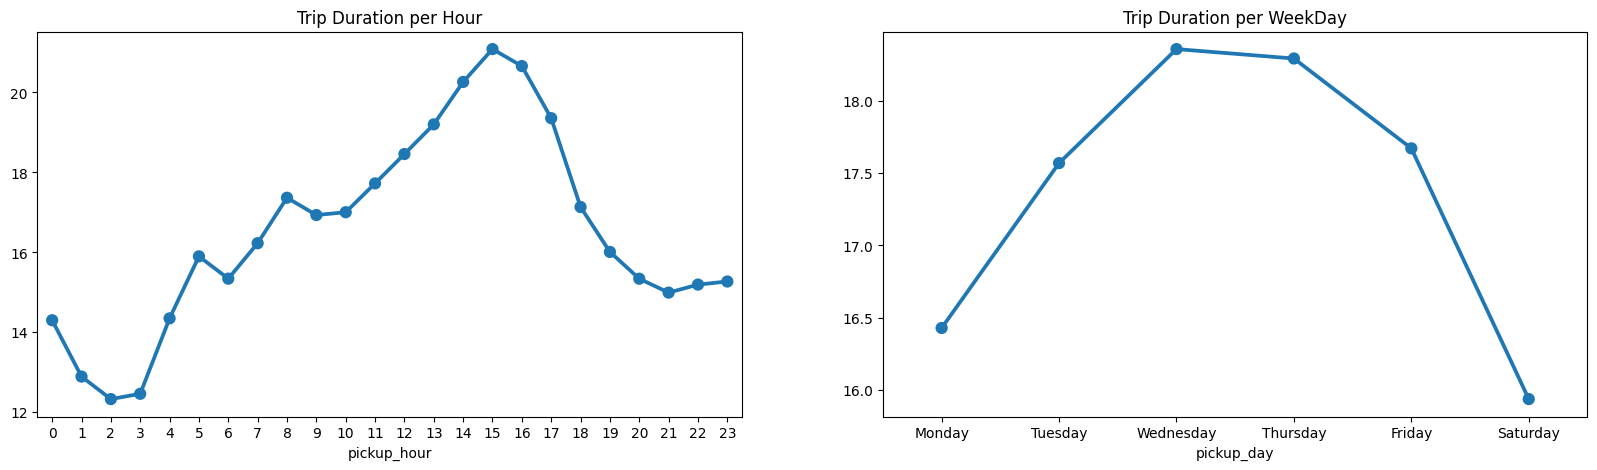

In [49]:
figure,(ax1,ax2)=plt.subplots(ncols=2,figsize=(20,5))
group1 = sept_df.groupby('pickup_hour').trip_duration.mean()
ax1.set_title('Trip Duration per Hour')
ax=sns.pointplot(x=group1.index, y=group1.values,ax=ax1)
ax2.set_title('Trip Duration per WeekDay')
group2 = sept_df.groupby('pickup_day').trip_duration.mean()
ax=sns.pointplot(x=group2.index, y=group2.values,ax=ax2,order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday'])

- Average trip duration is lowest at 2-3 AM when there is minimal traffic on the roads.
- Average trip duration is generally highest around 3 PM during the busy streets.
- Trip duration on an average is similar during early morning hours i.e. before 6 AM & late evening hours i.e. after 6 PM
- It is observed that trip duration on Wednesday and Thursday is longest among all days.

#### Trip Distance per hour and Weekday

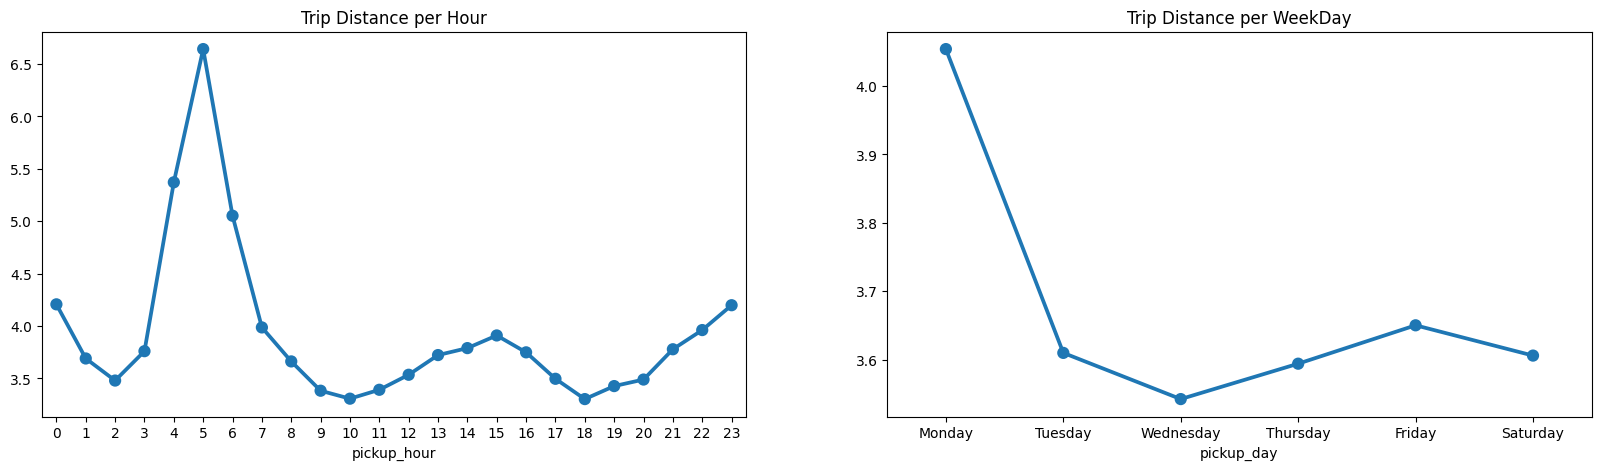

In [172]:
figure,(ax1,ax2)=plt.subplots(ncols=2,figsize=(20,5))
group1 = sept_df.groupby('pickup_hour').trip_distance.mean()
ax1.set_title('Trip Distance per Hour')
ax=sns.pointplot(x=group1.index, y=group1.values,ax=ax1)
ax2.set_title('Trip Distance per WeekDay')
group2 = sept_df.groupby('pickup_day').trip_distance.mean()
ax=sns.pointplot(x=group2.index, y=group2.values,ax=ax2,order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday'])

- Trip distance is highest during early morning hours which can account for some things like: Outstation trips taken during the weekends.
- Longer trips towards the city airport which is located in the outskirts of the city.
- Trip distance is fairly equal from morning till the evening varying around 3 - 4 mile.
- It starts increasing gradually towards the late night hours starting from evening till 5 AM and decrease steeply towards morning.
- Sunday being at the top may be due to outstation trips or night trips towards the airport.

In [53]:
df = sept_df.copy()
zonelookup = pd.read_csv('/content/drive/MyDrive/taxi+_zone_lookup.csv')

In [54]:
sept_df = pd.merge(sept_df,zonelookup[['LocationID','Borough']],left_on='PULocationID',right_on='LocationID',how='left')
sept_df['Borough'].value_counts()

Manhattan        2573642
Queens            273469
Unknown            41631
Brooklyn           15666
Bronx               3108
Staten Island        167
EWR                   43
Name: Borough, dtype: int64

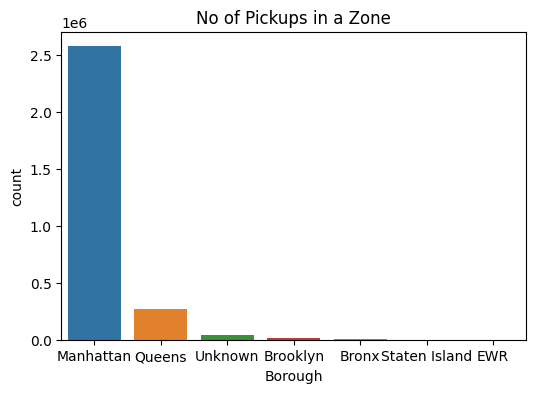

In [55]:
plt.figure(figsize=(6,4))
sns.countplot(x="Borough",data=sept_df).set(title='No of Pickups in a Zone')
plt.show()

In [173]:
sept_df['timestamp'] = sept_df.tpep_pickup_datetime.apply(
                            lambda x: int(datetime.timestamp(datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S")))
                        )
sept_df['day'] = sept_df['tpep_pickup_datetime'].dt.day
df_grouped = sept_df.groupby('PULocationID')
df_grouped

In [ ]:

data = []
i=0
# iterate for each locations
for group_name in tqdm(df_grouped.groups.keys()):   
    startdate = '2022-09-01 00:00:00'
    startdate = datetime.strptime(startdate, "%Y-%m-%d %H:%M:%S")
    tempdata = df_grouped.get_group(group_name)
    # iterate for each 10 minutes
    while startdate < datetime.strptime('2022-09-30 23:59:58', "%Y-%m-%d %H:%M:%S"):
        enddate = startdate + timedelta(minutes=10)
        startdate_timestamp = int(datetime.timestamp(startdate))
        enddate_timestamp = int(datetime.timestamp(enddate))
        month = startdate.month
        day = startdate.day
        # filter based on month and day
        tempdata1 = tempdata.loc[(tempdata['pickup_month']==month) & (tempdata['day']==day), ['timestamp']]
        # count number of pickups in given 10 minutes
        count = len(tempdata1.query('timestamp >= '+str(startdate_timestamp)+' ' \
                           + 'and timestamp < '+str(enddate_timestamp)))
        data.append((group_name, startdate_timestamp, count))
        # update startdate by 10 minutes
        startdate = enddate

In [ ]:
traindata = pd.DataFrame(data, columns=['location', 'timestamp', 'pickup_count'])
traindata['pickup_count'].unique()

In [ ]:
traindata.to_csv('traindata.csv')

In [ ]:
traindata.shape

(1105920, 3)

In [ ]:
def smoothing(x):
    n = len(x)
    r = []
    for i in range(n):
        if i==0:
            r.append(x[i]*.7 + x[i+1]*.3)
        elif i==1:
            r.append(x[i]*.6 + x[i+1]*.3 + x[i+2]*.1)
        elif i==n-1:
            r.append(x[i-1]*.3 + x[i]*.7)
        elif i==n-2:
            r.append(x[i-2]*.1 + x[i-1]*.3 + x[i]*.6)
        else:
            r.append(x[i-2]*.05 + x[i-1]*.2 + x[i]*.5 + x[i+1]*.2 + x[i+2]*.05)
    return np.round(np.array(r), 2)

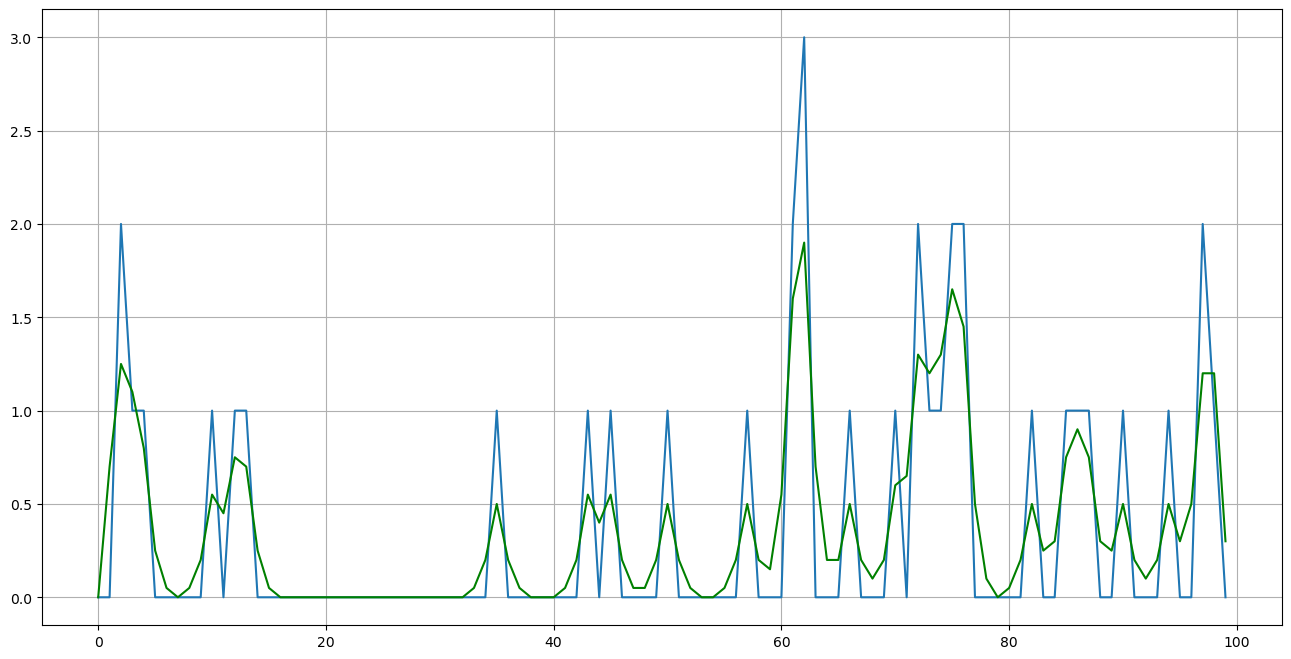

In [ ]:
x = traindata[traindata.location==4].pickup_count.values[:100]
plt.figure(figsize=(16,8))
plt.plot(x)
plt.plot(smoothing(x), color='green')
plt.grid()
plt.show()

In [ ]:
traindata.drop_duplicates(subset={'location','timestamp'}, keep='first', inplace=True)
np.all(traindata.location.values==np.sort(traindata.location.values))

True

In [ ]:
x = []
for i in tqdm(np.sort(traindata.location.unique())):
    x.extend(smoothing(traindata[traindata.location == i]['pickup_count'].values))
traindata['pickup_count'] = x

100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [00:13<00:00, 19.37it/s]


In [ ]:
def convert_unix_timestamp(unix_ts):
    dt = (datetime.fromtimestamp(unix_ts)).strftime('%Y-%m-%d %H:%M:%S')
    return dt
traindata['datetime'] = traindata['timestamp'].apply(lambda x:convert_unix_timestamp(x))
traindata['datetime']=pd.to_datetime(traindata['datetime'])
traindata['hour'] = traindata['datetime'].dt.hour
traindata['datetime'] = traindata['datetime'].dt.strftime('%Y-%m-%d')
traindata.head()

,location,timestamp,pickup_count,t-1,t-2,t-3,t-4,t-5,dt0,dt-1,...,ty1,ty2,avg_y,simple_MA,weighted_MA,exponential_MA,week_day,datetime,day,hour
100,1,1662064800,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0.00,0.000000,0.000000,4,2022-09-01,16,16
101,1,1662065400,0.05,0.00,0.00,0.00,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0.00,0.000000,0.000000,4,2022-09-01,16,16
102,1,1662066000,0.20,0.05,0.00,0.00,0.0,0.0,0.0,0.0,...,0.05,0.00,0.0,0.01,0.016667,0.016667,4,2022-09-01,17,17
103,1,1662066600,0.50,0.20,0.05,0.00,0.0,0.0,0.0,0.0,...,0.20,0.05,0.0,0.05,0.080000,0.077778,4,2022-09-01,17,17
104,1,1662067200,0.20,0.50,0.20,0.05,0.0,0.0,0.0,0.0,...,0.50,0.20,0.0,0.15,0.230000,0.218519,4,2022-09-01,17,17


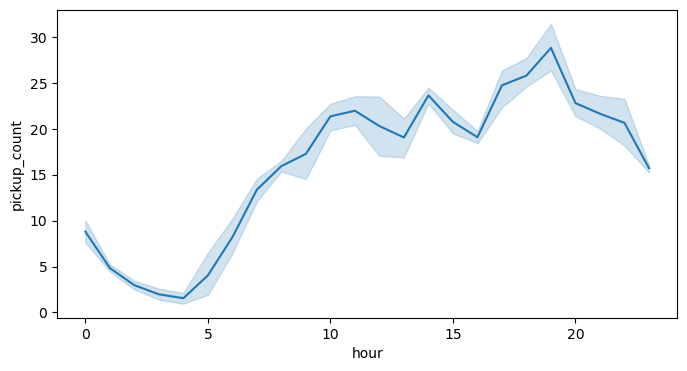

In [ ]:
plt.figure(figsize = (8,4))
df = traindata[(traindata.location==141)]
df = df[df['datetime']=='2022-09-02']
sns.lineplot(x="hour", y="pickup_count",data=df)
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller
ADF_result = adfuller(traindata.pickup_count, autolag=None)   
print(f'ADF Statistic: {ADF_result[0]}') 
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -14.856112001734722
p-value: 1.7473671120499796e-27


This results in an ADF statistic of -14.85 and a p-value of 1.74e-27. Here, the ADF statistic is a large negative number and the p-value is very much less than 0.05. Therefore, our time series is stationary.

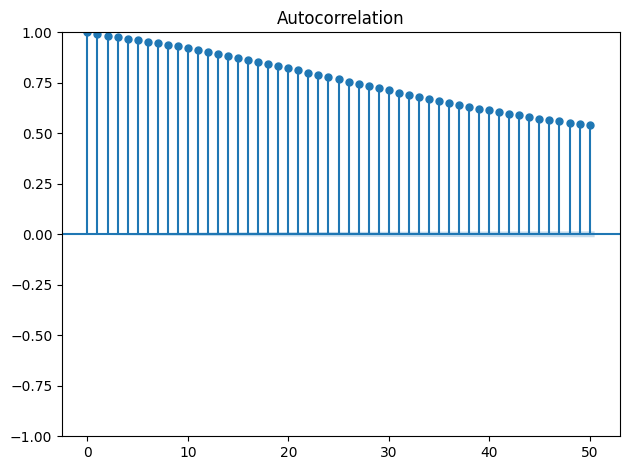

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(traindata.pickup_count, lags=50);
plt.tight_layout()


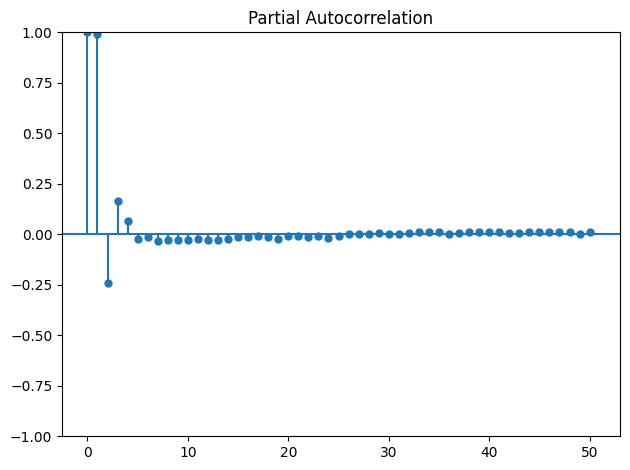

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(traindata.pickup_count, lags=50)
plt.tight_layout()

From the above graph, we can conclude that an ARMA(2,0) model is appropriate for this data because ACF plot is exponentially decaying and from PACF plot cutoff happens at lag 2 and p = 2. Therefore it is ARMA(2,0) model.

In [ ]:
def feature1(data):
    pd.options.mode.chained_assignment = None
    t_1 = []
    t_2 = []
    t_3 = []
    t_4 = []
    t_5 = []

    d_0 = []
    d_1 = []
    d_2 = []
    d__1 = []
    d__2 = []
    for i in tqdm(np.sort(data.location.unique())):
        temp = data[data.location == i]
        for j in range(len(temp)):
            t_1_temp = 0
            t_2_temp = 0
            t_3_temp = 0
            t_4_temp = 0
            t_5_temp = 0

            if j>0:
                t_1_temp = temp.iloc[j-1].pickup_count
            if j>1:
                t_2_temp = temp.iloc[j-2].pickup_count
            if j>2:
                t_3_temp = temp.iloc[j-3].pickup_count
            if j>3:
                t_4_temp = temp.iloc[j-4].pickup_count
            if j>4:
                t_5_temp = temp.iloc[j-5].pickup_count
            t_1.append(t_1_temp)
            t_2.append(t_2_temp)
            t_3.append(t_3_temp)
            t_4.append(t_4_temp)
            t_5.append(t_5_temp)

            d_0_temp = 0
            d_1_temp = 0
            d_2_temp = 0
            d__1_temp = 0
            d__2_temp = 0
            if j>93:
                d_2_temp = temp.iloc[j-94].pickup_count
            if j>94:
                d_1_temp = temp.iloc[j-95].pickup_count
            if j>95:
                d_0_temp = temp.iloc[j-96].pickup_count
            if j>96:
                d__1_temp = temp.iloc[j-97].pickup_count
            if j>97:
                d__2_temp = temp.iloc[j-98].pickup_count
            d_0.append(d_0_temp)
            d_1.append(d_1_temp)
            d_2.append(d_2_temp)
            d__1.append(d__1_temp)
            d__2.append(d__2_temp)
    
    data['t-1'] = t_1
    data['t-2'] = t_2
    data['t-3'] = t_3
    data['t-4'] = t_4
    data['t-5'] = t_5

    data['dt0'] = d_0
    data['dt-1'] = d__1
    data['dt-2'] = d__2
    data['dt+1'] = d_1
    data['dt+2'] = d_2
    return data
traindata = feature1(traindata)
traindata.head(100)

100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [14:10<00:00,  3.32s/it]


,location,timestamp,pickup_count,t-1,t-2,t-3,t-4,t-5,dt0,dt-1,dt-2,dt+1,dt+2
0,1,1662004800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1662005400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,1662006000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,1662006600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,1662007200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,1662061800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,1,1662062400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,1,1662063000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,1,1662063600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
def feature2(data):
    data['tdiff1'] = data.apply(lambda x:x['t-1']-x['t-2'], axis=1)
    data['tdiff2'] = data.apply(lambda x:x['t-2']-x['t-3'], axis=1)    
    data['tdiff3'] = data.apply(lambda x:x['t-3']-x['t-4'], axis=1)    
    data['tdiff4'] = data.apply(lambda x:x['t-4']-x['t-5'], axis=1)    
    
    data['ty1'] = data.apply(lambda x:x['t-1']-x['dt-1'], axis=1)    
    data['ty2'] = data.apply(lambda x:x['t-2']-x['dt-2'], axis=1)    
    
    data['avg_y'] = data.apply(lambda x:(x['dt-2']+x['dt-1']+x['dt0']+x['dt+1']+x['dt+2'])/5, axis=1)       
    return data
traindata = feature2(traindata)
traindata.head(100)

,location,timestamp,pickup_count,t-1,t-2,t-3,t-4,t-5,dt0,dt-1,dt-2,dt+1,dt+2,tdiff1,tdiff2,tdiff3,tdiff4,ty1,ty2,avg_y
0,1,1662004800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1662005400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,1662006000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,1662006600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,1662007200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,1662061800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,1,1662062400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,1,1662063000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,1,1662063600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
def feature3(data):
    n = 5
    
    data['simple_MA'] = data.apply(lambda x:(x['t-1']+x['t-2']+x['t-3']+x['t-4']+x['t-5'])/n, axis=1)
    data['weighted_MA'] = data.apply(lambda x:(n*x['t-1']+(n-1)*x['t-2']+(n-2)*x['t-3']+(n-3)*x['t-4']+(n-4)*x['t-5'])/(n*(n+1)/2), axis=1)
    alpha = 2/(1+n)
    data['exponential_MA'] = data.apply(lambda x:(alpha *  
                                  (x['t-1']+(1-alpha)*x['t-2']+((1-alpha)**2)*x['t-3']+((1-alpha)**3)*x['t-4']+((1-alpha)**4)*x['t-5'])), \
                                axis=1)       
    data['week_day'] = data.timestamp.apply(lambda x: datetime.fromtimestamp(x).isoweekday())
    return data
traindata = feature3(traindata)
traindata.head(100)

,location,timestamp,pickup_count,t-1,t-2,t-3,t-4,t-5,dt0,dt-1,...,tdiff2,tdiff3,tdiff4,ty1,ty2,avg_y,simple_MA,weighted_MA,exponential_MA,week_day
0,1,1662004800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
1,1,1662005400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
2,1,1662006000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,1,1662006600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
4,1,1662007200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,1662061800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
96,1,1662062400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
97,1,1662063000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
98,1,1662063600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


* simple_MA: which is equal to ([t-5] + [t-4] + [t-3] + [t-2] + [t-1]) / 5
* weighted_MA: which is equal to (5*[t-1] + 4*[t-2] + 3*[t-3] + 2*[t-4] + 1*[t-5]) / 15
*  exponential_MA: which is equal to alpha * { [t-1] + (1-alpha)*[t-2] + ((1-alpha)²)*x[t-3] + ((1-alpha)³)*[t-4] + ((1-alpha)⁴)*[t-5] } where alpha = 0.33
* week_day: Between 1 and 7 where it is 1 for Monday and 7 for Sunday.
* We have created 21 new features. So now we have total of 23 features.

In [158]:
traindata = pd.read_csv('/content/drive/MyDrive/traindata_allfeatures.csv',index_col=[0])

In [159]:
# remove data points for which some of the features could not be caculated.
traindata = traindata.query('timestamp >= 1662064800')
train = traindata.query('timestamp < 1664164452')
test = traindata.query('timestamp >= 1664164452')
print(train.shape,test.shape)
plot_df = pd.concat([train,test],axis=0)

(896000, 24) (184320, 24)


In [138]:
X_train = train.drop(columns=['pickup_count']).to_numpy()
y_train = train['pickup_count'].to_numpy()
X_test = test.drop(columns=['pickup_count']).to_numpy()
y_test = test['pickup_count'].to_numpy()
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(896000, 23) (896000,) (184320, 23) (184320,)


In [139]:
lr_reg=LinearRegression().fit(X_train, y_train)
lr_test_predictions = lr_reg.predict(X_test)

In [140]:
print ('{:<25}'.format('MAPE'), mean_absolute_percentage_error(y_test[np.round(y_test)!=0], lr_test_predictions[np.round(y_test)!=0]))
print ('{:<25}'.format('MAE => '), mean_absolute_error(np.round(y_test), lr_test_predictions))
print ('{:<25}'.format('R squared => '), r2_score(np.round(y_test), lr_test_predictions))
print ('{:<25}'.format('RMSE => '), mean_squared_error(np.round(y_test), lr_test_predictions, squared=False))

MAPE                      0.20137645170801566
MAE =>                    0.33188116075434265
R squared =>              0.9887993900587739
RMSE =>                   0.9255901156390308


In [141]:
del train['pickup_count']
features = train.columns
list(features[np.argsort(np.abs(lr_reg.coef_))[::-1][:10]])

['tdiff1',
 't-1',
 'ty1',
 'dt-1',
 'exponential_MA',
 'weighted_MA',
 'simple_MA',
 'avg_y',
 'tdiff4',
 't-5']

In [142]:
def objective(space):
    warnings.filterwarnings(action='ignore', category=UserWarning)
    model = xgb.XGBRegressor(
                    objective = "reg:squarederror",
                    eval_metric = "mae",
                    booster = "gbtree",
                    tree_method = "hist",
                    grow_policy = "lossguide",
                    n_estimators = space['n_estimators'], 
                    max_depth = space['max_depth'],
                    learning_rate = space['learning_rate'],
                    reg_lambda = space['reg_lambda'],
                )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    print("MAE = " + str(mae))
    return{'loss':mae, 'status': STATUS_OK, 'model': model, 'params': space }

In [143]:
space = {
    'n_estimators' : hp.choice('n_estimators', [30, 50, 100]),
    'max_depth' : hp.choice('max_depth', range(3, 10, 1)),
    "learning_rate": hp.quniform("learning_rate", 0.01, 0.5, 0.01),
    "reg_lambda": hp.choice("reg_lambda", [10e-1, 10e0, 10e1])
}

In [144]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=25,
            trials=trials)

MAE = 0.2998281980607277
MAE = 0.30051386910290045
MAE = 0.31508409473288757
MAE = 0.7430877471574058
MAE = 0.30010993876560155
MAE = 0.31807886334731017
MAE = 0.298569107520736
MAE = 0.31508409473288757
MAE = 0.302045993514972
MAE = 0.3097868194876148
MAE = 0.31420251885098976
MAE = 0.3089134938723484
MAE = 0.2980846161279795
MAE = 0.3077642152383457
MAE = 0.31964815195147805
MAE = 0.5065418555841218
MAE = 0.3138735166635754
MAE = 0.29649618155430335
MAE = 0.425961955364918
MAE = 0.2952378854083381
MAE = 0.30043902211441165
MAE = 0.29611636643972084
MAE = 0.29583698418136894
MAE = 0.29890973106241486
MAE = 0.2956412460761325
100%|██████████| 25/25 [03:45<00:00,  9.01s/trial, best loss: 0.2952378854083381]


In [145]:
trials.best_trial['result']['params']

{'learning_rate': 0.16,
 'max_depth': 8,
 'n_estimators': 100,
 'reg_lambda': 100.0}

In [146]:
model = trials.best_trial['result']['model']
model

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=None, gpu_id=None, grow_policy='lossguide',
             importance_type=None, interaction_constraints=None,
             learning_rate=0.16, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None, ...)

In [147]:
y_pred = model.predict(X_test)

In [148]:
print ('{:<25}'.format('MAPE'), mean_absolute_percentage_error(y_test[np.round(y_test)!=0], y_pred[np.round(y_test)!=0]))
print ('{:<25}'.format('MAE => '), mean_absolute_error(np.round(y_test), y_pred))
print ('{:<25}'.format('R squared => '), r2_score(np.round(y_test), y_pred))
print ('{:<25}'.format('RMSE => '), mean_squared_error(np.round(y_test), y_pred, squared=False))


MAPE                      0.1658935525819234
MAE =>                    0.32685990053993086
R squared =>              0.9871177874925652
RMSE =>                   0.9926430381810274


<Axes: >

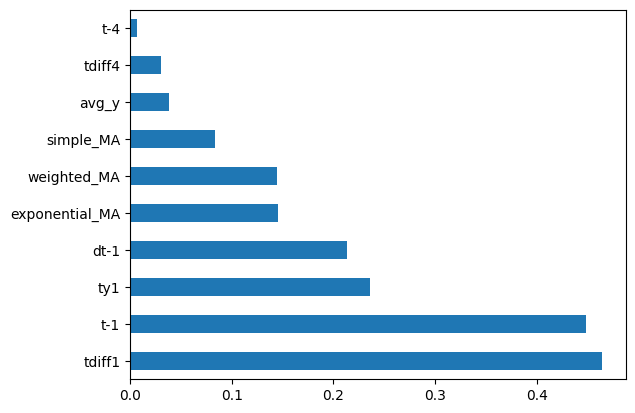

In [149]:
list(features[np.argsort(np.abs(lr_reg.coef_))[::-1][:10]])
feature_importances = pd.Series(lr_reg.coef_, index=features)
feature_importances.nlargest(10).plot(kind='barh')

<Axes: >

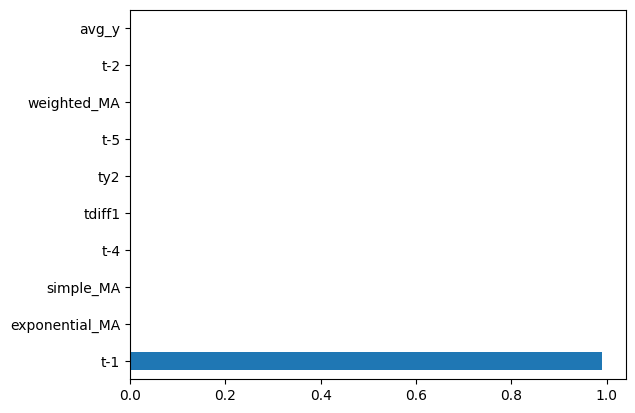

In [150]:
#list(features[np.argsort(np.abs(model.feature_importances_))[::-1][:10]])
%matplotlib inline
feature_importances = pd.Series(model.feature_importances_, index=features)
feature_importances.nlargest(10).plot(kind='barh')

In [168]:
from datetime import datetime
plot_df = plot_df[["timestamp","pickup_count"]]
def convert_unix_timestamp(unix_ts):
    dt = (datetime.fromtimestamp(unix_ts)).strftime('%Y-%m-%d %H:%M:%S')
    return dt

plot_df['datetime'] = plot_df['timestamp'].apply(lambda x:convert_unix_timestamp(x))
plot_df['datetime']=pd.to_datetime(plot_df['datetime'])
plot_df['day'] = plot_df['datetime'].dt.day
# plot_df['datetime']=pd.to_datetime(plot_df['datetime'])
# plot_df['hour'] = plot_df['datetime'].dt.hour
plot_df['datetime'] = plot_df['datetime'].dt.strftime('%Y-%m-%d')
plot_df['lr_test_predictions'] = ''
plot_df['lr_test_predictions'][plot_df['timestamp'] >= 1664164452] = np.round(lr_test_predictions)
plot_df['xg_preds'] = ''
plot_df['xg_preds'][plot_df['timestamp'] >= 1664164452] = np.round(y_pred)
plot_df['lr_test_predictions'][plot_df['lr_test_predictions'] == ''] = -1
plot_df['xg_preds'][plot_df['xg_preds'] == ''] = -1
plot_df_grouped = plot_df.groupby(['day']).agg({'lr_test_predictions':'sum','pickup_count':'sum','xg_preds':'sum'}).reset_index()
plot_df_grouped['lr_test_predictions'] = np.where(plot_df_grouped['lr_test_predictions']>0,plot_df_grouped['lr_test_predictions'],'')
plot_df_grouped['xg_preds'] = np.where(plot_df_grouped['xg_preds']>0,plot_df_grouped['xg_preds'],'')
plot_df_grouped['lr_test_predictions'].iloc[0] = ''
plot_df_grouped['xg_preds'].iloc[0] = ''
plot_df_grouped = plot_df_grouped.set_index(['day'])
plot_df_grouped.lr_test_predictions.replace('',np.nan,regex = True,inplace=True)
plot_df_grouped.xg_preds.replace('',np.nan,regex = True,inplace=True)

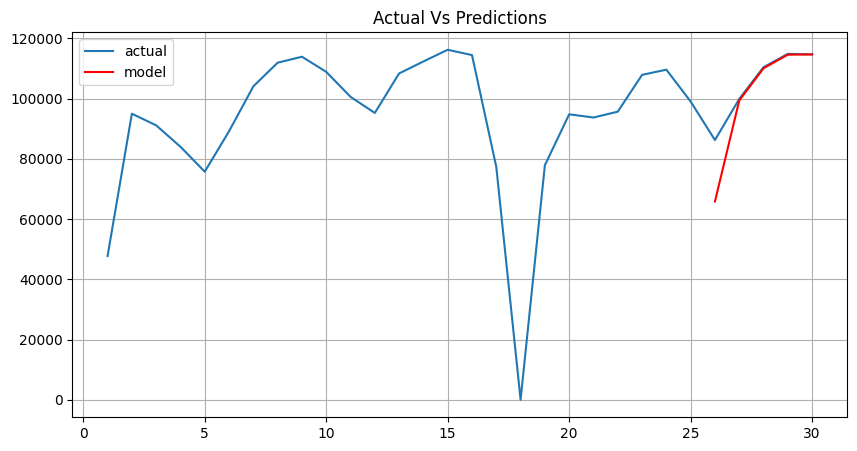

In [170]:
plt.figure(figsize=(10, 5))
plt.title("Actual Vs Predictions")
plt.plot(plot_df_grouped['pickup_count'], label="actual")
plt.plot(plot_df_grouped['lr_test_predictions'], color='r', label="model")
plt.legend()
plt.grid(True)

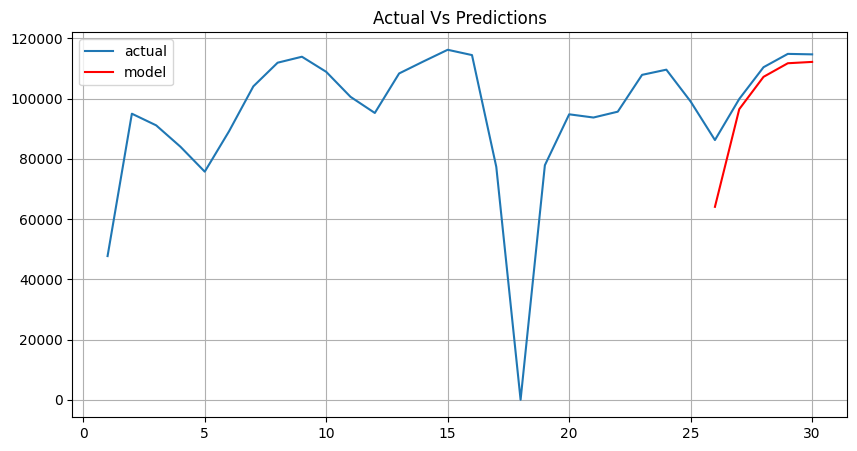

In [171]:
plt.figure(figsize=(10, 5))
plt.title("Actual Vs Predictions")
plt.plot(plot_df_grouped['pickup_count'], label="actual")
plt.plot(plot_df_grouped['xg_preds'], color='r', label="model")
plt.legend()
plt.grid(True)